# Support Vector Machine

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [28]:
# Loading movie data into a dataframe
data = pd.read_csv('data/moviedata.csv').dropna()

def get_num_words_per_sample(sample_texts):
    '''Returns the median number of words per sample given corpus.'''
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def plot_sample_length_distribution(sample_texts):
    '''Plots the sample length distribution.'''

    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

In [29]:
get_num_words_per_sample(data.line.tolist())

7.0

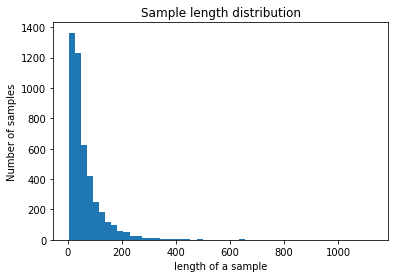

In [24]:
plot_sample_length_distribution(data.line.tolist())

In [30]:
# Splitting dataframe into features and target
X = data['line']
y = data['character_name']
X_train, X_test, y_train, ytest = train_test_split(X, y, 
                                                   test_size=0.2, 
                                                   random_state=222,
                                                   stratify=y)

## Vectorizing the Parameters
Vectorizes the parameters with n-gram model, including unigrams and bigrams.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text
# We only want unigrams and bigrams, so we will put 1 and 2
NGRAM_RANGE = (1,2)

# Limit on the number of features. We use the top 20k features.
# Note: not sure what our number should be for this lol I'll do the same
# I guess.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be
# discarded (translation: minimum number of times a word needs to be
# used to be considered in the model.)
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    '''Vectorizes texts as n-gram vectors.
    1 text = 1 tf-idf vector the length of vocabulary 
    of unigrams + bigrams. 
    
    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.
    
    # Returns
        x_train, x_val: vectorized training and validation texts
    '''

    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
        'ngram_range': NGRAM_RANGE, # use unigrams and bigrams
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': TOKEN_MODE, # Split text into word tokens
        'min_df': MIN_DOCUMENT_FREQUENCY
    }

    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val


In [32]:
x_train, x_val = ngram_vectorize(X_train, y_train, X_test)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2072: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


*Source: https://developers.google.com/machine-learning/guides/text-classification/step-3*

## Building, Training, Evaluating

In [ ]:
def _get_last_layer_units_and_activation(num_classes):
    '''Gets the # units and activation function for the last
    network layer.
    
    # Arguments
        num_classes: int, number of classes.
    
    # Returns
        units, activation values.
    '''
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes

    return units, activation

In [ ]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    '''Creates an instance of a multi-layer perceptron model.'''

    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        models.add(Dense(units=units, activation='relu'))
        models.add(Dropout(rate=dropout_rate))
    
    model.add(Dense(units=op_units, activation=op_activation))
    return model

*Source: https://developers.google.com/machine-learning/guides/text-classification/step-4*